Note: 
The following code is in the process of refinement, code comments and text still need to be partially translated into English and added.

Nota: 
Il seguente codice è in fase di rifinizione, i commenti ai codici e i testi devono essere ancora parzialmente tradotti in inglese e aggiunti.

# Import libraries


In [ ]:
from google.colab import drive
drive.mount ('/content/gdrive')

In [ ]:
# Main libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import kurtosis, skew
from scipy import signal

#Processing libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from imblearn.over_sampling import SMOTE

# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale=1.8)


# Load useful DataFrame

In this part of the code, dataframes are created with only the most useful .csv files for failure analysis.

In [ ]:
def build_dict(file_path):
  dict_dfs={}
  if "failure_status" in file:
    dict_dfs['failure_status'] = pd.read_csv(file_path)
  elif "nav_info-airspeed" in file:
    dict_dfs['airspeed'] = pd.read_csv(file_path)
  elif "nav_info-errors" in file:
    dict_dfs['errors'] = pd.read_csv(file_path)
  elif "nav_info-pitch" in file:
    dict_dfs['pitch'] = pd.read_csv(file_path)
  elif "nav_info-roll" in file:
    dict_dfs['roll'] = pd.read_csv(file_path)
  elif "nav_info-velocity" in file:
    dict_dfs['velocity'] = pd.read_csv(file_path)
  elif "nav_info-yaw" in file:
    dict_dfs['yaw'] = pd.read_csv(file_path)
  elif "local_position-velocity" in file:
    dict_dfs['local_position'] = pd.read_csv(file_path)
  elif "imu-data.csv" in file:
    dict_dfs['imu_data'] = pd.read_csv(file_path)
  return dict_dfs

Nel codice sottostante va modificato ad ogni volta la root_folder prendendo ogni volta una delle diverse cartelle all'interno della cartella processed del dataset. Per la prima parte di codice si lavora su un solo volo alla volta, andando a creare un dataframe con solo i dati desiderati. Una volta ottenuto un dataframe per ogni volo si prosegue unendo tutto. 

In [ ]:
# Set the root folder
root_folder =  "/content/gdrive/MyDrive/ManutenzionePreventiva/processed/carbonZ_2018-10-18-11-06-06_engine_failure_with_emr_traj"

# Create an empty dictionary where the dataframes will be stored
dataframes = {}

# Loop through all folders and files in the root folder
for subdir, dirs, files in os.walk(root_folder):
    for file in files:
        file_path = os.path.join(subdir, file)
        dataframes.update(build_dict(file_path))

# Frequencies Analisys

Frequency analysis is performed on the sensors' sampling rates.



In [ ]:
def get_frequency(df):
    time_col = df['%time']
    time_diff = pd.to_timedelta(time_col.diff().mean())
    freq = pd.Timedelta('1S') / time_diff
    return freq

In [ ]:
def get_frequencies(dataframes):
    """
    Questa funzione prende in input un dizionario di dataframes di Pandas e restituisce
    un dizionario contenente le frequenze di campionamento di ciascun dataframe.
    """
    frequencies = {}
    for key, df in dataframes.items():
        frequencies[key] = get_frequency(df)
    return frequencies


In [ ]:
def get_min_max_frequencies(dataframes):
    """
    Questa funzione prende in input un dizionario di dataframes di Pandas e restituisce una tupla contenente
    la frequenza minima e la frequenza massima tra tutti i dataframes.
    """
    frequencies = list(get_frequencies(dataframes).values())
    min_freq = min(frequencies)
    max_freq = max(frequencies)
    return min_freq, max_freq

min_freq, max_freq = get_min_max_frequencies(dataframes)
print(f"Min frequency is: {min_freq:.2f} Hz.")
print(f"Max frequency is: {max_freq:.2f} Hz.")


In [ ]:
for name, df in dataframes.items():
    freq = get_frequency(df)
    print(f'Frequency of {name} is: {freq:.2f} Hz')

# Resample

All dataframes are brought to a uniform sampling frequency of 20Hz.



In [ ]:
def resample(df):
  new_len = len(df) * 20 / (get_frequency(df))
  # Converti la colonna %time in un indice di data/ora
  df.index = pd.to_datetime(df['%time'], unit='ns')

  # Resample del dataframe con la frequenza di campionamento desiderata
  new_freq = '50L' # 20 Hz in nanosecondi
  new_df = df.resample(new_freq).last()

  # Propaga l'ultimo valore disponibile (forward fill)
  new_df = new_df.ffill()

  # Riporta l'indice all'intervallo di tempo originale
  new_df = new_df.loc[df.index.min():df.index.max()]

  return new_df

In [ ]:
airspeed = pd.DataFrame()
airspeed = resample(dataframes['airspeed'])
airspeed.name = 'airspeed'

velocity = pd.DataFrame()
velocity = resample(dataframes['velocity'])
velocity.name = 'velocity'

roll = pd.DataFrame()
roll = resample(dataframes['roll'])
roll.name = 'roll'

pitch = pd.DataFrame()
pitch = resample(dataframes['pitch'])
pitch.name = 'pitch'

yaw = pd.DataFrame()
yaw = resample(dataframes['yaw'])
yaw.name = 'yaw'

errors = pd.DataFrame()
errors = resample(dataframes['errors'])
errors.name = 'errors'

local_position = pd.DataFrame()
local_position = resample(dataframes['local_position'])
local_position.name = 'local_position'

failure_status = pd.DataFrame()
failure_status = resample(dataframes['failure_status'])
failure_status.name = 'failure_status'

imu_data = pd.DataFrame()
imu_data = resample(dataframes['imu_data'])
imu_data.name = 'imu_data'


# Select feature

Within the dataframes, only the columns of greater interest are selected.



In [ ]:
def selection_attribute(df):
  if df.name == 'imu_data':
    df = df[['field.orientation.x',	'field.orientation.y',	'field.orientation.z', 'field.angular_velocity.x','field.angular_velocity.y', 'field.angular_velocity.z',  
                     'field.linear_acceleration.x', 'field.linear_acceleration.y', 'field.linear_acceleration.z']]

  elif df.name == 'failure_status':
    df = df[['field.data']]

  elif df.name == 'local_position':
    df = df[[ 'field.twist.linear.x', 'field.twist.linear.y',
       'field.twist.linear.z', 'field.twist.angular.x',
       'field.twist.angular.y', 'field.twist.angular.z']]

  elif df.name == 'errors':
    df = df[['field.alt_error', 'field.aspd_error','field.xtrack_error']]

  elif df.name == 'yaw':
    df['delta_yaw'] = df['field.commanded'] - df['field.measured']
    df = df[[ 'delta_yaw']]

  elif df.name == 'pitch':
    df['delta_pitch'] = df['field.commanded'] - df['field.measured']
    df = df[[ 'delta_pitch']]

  elif df.name == 'roll':
    df['delta_roll'] = df['field.commanded'] - df['field.measured']
    df = df[[ 'delta_roll']]

  elif df.name == 'velocity':
    df['delta_x'] = df['field.des_x'] - df['field.meas_x']
    df['delta_y'] = df['field.des_y'] - df['field.meas_y']
    df['delta_z'] = df['field.des_z'] - df['field.meas_z']

    df = df[[ 'delta_x','delta_y', 'delta_z' ]]

  elif df.name == 'airspeed':
    df['delta_roll'] = df['field.commanded'] - df['field.measured']
    df = df[[ 'delta_roll']]

  else:
    return "error"

  return df

In [ ]:
imu_data = selection_attribute(imu_data)
failure_status = selection_attribute(failure_status)
local_position = selection_attribute(local_position)
errors = selection_attribute(errors)
yaw = selection_attribute(yaw)
pitch = selection_attribute(pitch)
roll = selection_attribute(roll)
velocity = selection_attribute(velocity)
airspeed = selection_attribute(airspeed)

In [ ]:
times = []
df_names = ['imu_data', 'failure_status', 'local_position', 'errors', 'yaw', 'pitch', 'roll', 'velocity', 'airspeed']
for df_name in df_names:
    df = globals()[df_name]
    time_min = df.index[0]
    times.append(time_min)

    time_max = df.index[-1]
    times.append(time_max)


min_time = min(times)
max_time = max(times)


In [ ]:
fly_df = pd.DataFrame(index=pd.date_range(start=min_time, end=max_time, freq='50ms'))

In [ ]:
for df_name in df_names:
    df = globals()[df_name]
    fly_df = pd.merge(fly_df, df, how='outer', left_index=True, right_index=True, suffixes=('', f'_{df_name}'))

#This is only for 'no_fault' class -> Add label to 0
#fly_df['field.data'] = fly_df['field.data'].fillna(0)



Si salva un file csv per il dataframe ottenuto, il codice è stato utilizzato per generare un dataframe (e quindi un file csv) per ogni cartella (cioè per ogni volo) presente nella cartella processed del dataset originario. 

In [ ]:
fly_df.to_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/processed/carbonZ_2018-10-18-11-06-06_engine_failure_with_emr_traj.csv.csv', index_label = '%time') 
fly_df

# Feature calculation

Si calcolano le feature nel tempo e in frequenza. Per ognuna delle colonne dei guasti si calcola le metriche sottostanti nel tempo e in frequenza (dopo aver effettuato la trasformata di Fourier). 
Le feature in frequenza e nel tempo vengono calcolate su unan finestra di 1s (20 campioni a frequenza 20Hz) e con una sovrapposizione tra le finestre di 0.5s (step di 10 campioni a frequenza 20Hz). 

## Time

In [ ]:
# definisci le funzioni per calcolare le metriche richieste
def calculate_mean(x):
    return np.mean(x)

def calculate_variance(x):
    return np.var(x)

def calculate_mae(x):
    return np.mean(np.abs(x - np.mean(x)))

def calculate_rmse(x):
    return np.sqrt(np.mean((x - np.mean(x))**2))

def calculate_rms(x):
    return np.sqrt(np.mean(x**2))

def calculate_kurtosis(x):
    return kurtosis(x)

def calculate_skewness(x):
    return skew(x)

def calculate_impulse_factor(x):
    return np.max(np.abs(x)) / np.mean(np.abs(x))

def calculate_p25(x):
  return x.quantile(q = 0.25)

def calculate_p50(x):
  return x.quantile(q = 0.5)

def calculate_p75(x):
  return x.quantile(q = 0.75)


In [ ]:
def calculate_stats(df):
  # crea un dizionario vuoto per i risultati
  results = {}

  # calcola le metriche per ciascuna colonna del DataFrame
  for col in df.columns:
    if col == '%time':  # salta la colonna %time
      results[col] = df[col].iat[0]
    elif col == 'label':  # salta la colonna label
      results[col] = df[col].mode()[0]
    else:
        results[col + '_mean'] = calculate_mean(df[col])
        results[col + '_variance'] = calculate_variance(df[col])
        results[col + '_mae'] = calculate_mae(df[col])
        results[col + '_rmse'] = calculate_rmse(df[col])
        results[col + '_rms'] = calculate_rms(df[col])
        results[col + '_kurtosis'] = calculate_kurtosis(df[col])
        results[col + '_skewness'] = calculate_skewness(df[col])
        results[col + '_impulse_factor'] = calculate_impulse_factor(df[col])
        results[col + '_p25'] = calculate_p25(df[col])
        results[col + '_p50'] = calculate_p50(df[col])
        results[col + '_p75'] = calculate_p75(df[col])

  return results


This code creates a new DataFrame named `time_df` to store calculated statistics. The root folder containing the data is set as root_folder. The code then loops through each subdirectory, file, and its path in the root folder using `os.walk()`. It loads each csv file into a DataFrame using `pd.read_csv()`, drops any rows with missing data, and creates a new column named 'label' with the same values as '`field.data`'. It also drops the columns '`field.data`' and '`delta_roll_airspeed`' if they exist.

The DataFrame is then divided into blocks of 1 second with an overlap of 0.5 seconds. Each block is saved as a new DataFrame and operations are performed on it using the `calculate_stats()` function, which is not defined in this code snippet. The resulting statistics are appended to `time_df` using `df.append()`.

Finally, the index of the resulting DataFrame is set to '`%time`' using `time_df`.`set_index()` and the resulting DataFrame is saved to a csv file in the specified path using `time_df.to_csv()`.

In [ ]:
# Create an empty DataFrame to store the calculated stats
time_df = pd.DataFrame()

# Set the path to the root folder containing the data
root_folder = '/content/gdrive/MyDrive/ManutenzionePreventiva/failures/engine'

# Loop through each subdirectory, file, and its path in the root folder
for subdir, dirs, files in os.walk(root_folder):
    for file in files:
        file_path = os.path.join(subdir, file)
        
        # Load the csv file into a DataFrame
        df = pd.read_csv(file_path)

        # Drop any rows with missing data
        df = df.dropna()

        # Create a new column 'label' and set its value to the 'field.data' column
        df['label'] = df['field.data']

        # Drop the 'field.data' and 'delta_roll_airspeed' columns if they exist
        if 'field.data' in df.columns:  
          df = df.drop(columns=['field.data'])
        if 'delta_roll_airspeed' in df.columns:  
          df = df.drop(columns=['delta_roll_airspeed'])

        # Divide the DataFrame into blocks of 1 second with an overlap of 0.5 seconds
        boxes = []
        for i in range(0, len(df), 10):  
          box = df.iloc[i:i+20]
          boxes.append(box)

        # Save each block as a new DataFrame and perform operations on it
        for i, box in enumerate(boxes):
          df_box = pd.DataFrame(box)
          time_df = time_df.append(calculate_stats(df_box), ignore_index=True)

# Set the index of the resulting DataFrame to '%time'
time_df = time_df.set_index('%time')

# Save the resulting DataFrame to a csv file
time_df.to_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/time_engine.csv')

## Frequency


This function takes a DataFrame `df` as input and returns a new DataFrame containing the FFT of the data in the input DataFrame.
The function first creates an empty DataFrame `result` to store the FFT data.
For each column in the input DataFrame, the function checks if it is the `'%time'` or `'label'` column. If it is, the function skips that column and moves on to the next one.
Otherwise, the function calculates the FFT of the column using the `np.fft.fft()` function and stores the result in a new column in the `result` DataFrame with a name that is derived from the column name.
Finally, the function returns the `result` DataFrame containing the FFT of the data in the input DataFrame.

In [ ]:

# Define a function to calculate FFT of data in a DataFrame
def fft(df):
  result = pd.DataFrame()
  for col in df.columns:
    if col == '%time':   # Skip the '%time' column
      result[col] = df[col]
    elif col == 'label':   # Skip the 'label' column
      result[col] = df[col]
    else:
        # Calculate FFT of the column and store the result in a new column in the result DataFrame
        result[col + '_fft'] = np.fft.fft(df[col])
  return result

This code defines several functions for calculating various statistics of a signal. 

`calculate_peak_frequency(x)` uses the fast Fourier transform to compute the frequencies of the signal, finds the amplitude of the signal, and returns the frequency with the maximum amplitude.

`calculate_band_power(x)` uses the periodogram method to compute the power spectral density of the signal, finds the indices of the frequency range 0 to 20 Hz, and integrates the power spectral density over that frequency range.

`calculate_peak_power(x)` computes the power spectral density of the signal, finds the maximum power in the spectrum, and returns that value.

`calculate_p25(x)`, `calculate_p50(x)`, and `calculate_p75(x)` find the 25th, 50th, and 75th percentiles of the signal, respectively.

`calculate_mean(x)` computes the absolute value of the signal, finds the mean value of the resulting signal, and returns that value.

In [ ]:
# Define a function to calculate the peak frequency of a signal
def calculate_peak_frequency(x):
  # Compute the frequencies using the fast Fourier transform
  frequencies = np.fft.fftfreq(len(x))
  
  # Compute the amplitudes of the signal
  amplitudes = np.abs(x)
  
  # Find the frequency with the maximum amplitude
  peak_frequency = np.abs(frequencies[np.argmax(amplitudes)])

  return peak_frequency

# Define a function to calculate the band power of a signal
def calculate_band_power(x):
    # Compute the power spectral density using the periodogram method
    f, Pxx = scipy.signal.periodogram(x, 20)
    
    # Find the indices of the frequency range 0 to 20 Hz
    ind_min = scipy.argmax(f > 0) - 1
    ind_max = scipy.argmax(f > 20) - 1
    
    # Integrate the power spectral density over the frequency range
    return scipy.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

# Define a function to calculate the peak power of a signal
def calculate_peak_power(x):
  # Compute the power spectral density of the signal
  power_spectrum = np.abs(x)**2
  
  # Find the maximum power in the spectrum
  peak_power = np.max(power_spectrum)

  return peak_power

# Define functions to calculate the 25th, 50th, and 75th percentiles of a signal
def calculate_p25(x):
  x = np.abs(x)
  return x.quantile(q = 0.25)

def calculate_p50(x):
  x = np.abs(x)
  return x.quantile(q = 0.5)

def calculate_p75(x):
  x = np.abs(x)
  return x.quantile(q = 0.75)

# Define a function to calculate the mean value of a signal
def calculate_mean(x):
  x = np.abs(x)
  return np.mean(x)

This function takes a DataFrame `df` as input and returns a dictionary of calculated statistics for each column of the DataFrame.

The function first creates an empty dictionary `results` to store the calculated statistics.

For each column in the DataFrame, the function checks if it is the `'%time'` or `'label'` column. If it is, the function skips that column and moves on to the next one. 

Otherwise, the function calculates the peak frequency, peak power, band power, mean, and percentile values for the column using other functions that are not shown in this code snippet. The calculated statistics are then stored in the `results` dictionary with keys that are derived from the column name.

Finally, the function returns the `results` dictionary containing the calculated statistics for each column of the input DataFrame.

In [ ]:
# Define a function to calculate statistics of FFT data in a DataFrame
def calculate_stats_fft(df):
  # Create an empty dictionary to store the results
  results = {}

  # Calculate the statistics for each column of the DataFrame
  for col in df.columns:
    if col == '%time':  # Skip the '%time' column
        results[col] = df[col].iat[0]
    elif col == 'label':  # Skip the 'label' column
        results[col] = df[col].mode()[0]
    else:
        # Calculate peak frequency, peak power, band power, mean, and percentile values for the column
        results[col + '_peak_frequency'] = calculate_peak_frequency(df[col])
        results[col + '_peak_power'] = calculate_peak_power(df[col])
        results[col + '_band_power'] = calculate_band_power(df[col])
        results[col + '_mean'] = calculate_mean(df[col])
        results[col + '_p25'] = calculate_p25(df[col])
        results[col + '_p50'] = calculate_p50(df[col])
        results[col + '_p75'] = calculate_p75(df[col])

  return results


This code reads data files from a root folder and subdirectories, calculates the FFT of the data, and calculates statistics of smaller boxes of the FFT data. 

`frequency_df` and `fft_df` are created as empty DataFrames to store the frequency and FFT data.

The `os.walk()` function is used to traverse through the directory and subdirectories specified by `root_folder`. For each file in the directories, its path is retrieved, and the data is loaded into a DataFrame. Null values are dropped, and the 'field.data' column is renamed to 'label'.

If there exists a 'delta_roll_airspeed' column, it is dropped, and the FFT of the data is calculated. The FFT data is then split into smaller boxes of length 20, and the statistics of each box are calculated using another function `calculate_stats_fft()`. The resulting statistics are appended to `frequency_df`.

Finally, the `'%time'` column is set as the index of `frequency_df`, and the DataFrame is saved to a CSV file.

In [ ]:
# Create empty DataFrames for frequency and FFT data
frequency_df = pd.DataFrame()
fft_df = pd.DataFrame()

# Set the root folder for the data files
root_folder = '/content/gdrive/MyDrive/ManutenzionePreventiva/failures/ailerons'

# Traverse through the directory and subdirectories to read the data files
for subdir, dirs, files in os.walk(root_folder):
    for file in files:
        # Get the path for each data file
        file_path = os.path.join(subdir, file)
        
        # Read the data file into a DataFrame and drop any null values
        df = pd.read_csv(file_path)
        df = df.dropna()
        
        # Rename the 'field.data' column to 'label'
        df['label'] = df ['field.data']
        if 'field.data' in df.columns:
          df = df.drop(columns=['field.data'])
        
        # Drop the 'delta_roll_airspeed' column if it exists
        if 'delta_roll_airspeed' in df.columns:  
          df = df.drop(columns=['delta_roll_airspeed'])
        
        # Calculate the FFT of the data and split it into smaller boxes of length 20
        fft_df = fft(df)
        boxes = []
        for i in range(0, len(fft_df), 10):  
          box = fft_df.iloc[i:i+20]
          boxes.append(box)
        
        # Calculate the statistics of each box and append them to the frequency DataFrame
        for i, box in enumerate(boxes):
          df_box = pd.DataFrame(box)
          frequency_df = frequency_df.append(calculate_stats_fft(df_box), ignore_index=True)

# Set the index of the frequency DataFrame to '%time' and save it to a CSV file
frequency_df = frequency_df.set_index('%time')
frequency_df.to_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/frequency_ailerons.csv')


In [ ]:
frequency_df

,field.orientation.x_fft_peak_frequency,field.orientation.x_fft_peak_power,field.orientation.x_fft_band_power,field.orientation.x_fft_mean,field.orientation.x_fft_p25,field.orientation.x_fft_p50,field.orientation.x_fft_p75,field.orientation.y_fft_peak_frequency,field.orientation.y_fft_peak_power,field.orientation.y_fft_band_power,...,delta_y_fft_p50,delta_y_fft_p75,delta_z_fft_peak_frequency,delta_z_fft_peak_power,delta_z_fft_band_power,delta_z_fft_mean,delta_z_fft_p25,delta_z_fft_p50,delta_z_fft_p75,label
%time,,,,,,,,,,,,,,,,,,,,,
2018-09-11 18:55:44.950,0.000000,48681.082163,4013.378679,66.389664,33.098684,56.598499,82.229730,0.000000,81061.343431,-1456.710887,...,3364.925632,3885.261152,0.350000,8.706178e+05,9906.451768,420.712972,313.938153,406.577359,491.691169,0.0
2018-09-11 18:55:45.450,0.150000,21583.365426,1771.900956,63.267287,39.305579,59.843549,81.830125,0.500000,17596.422779,-5815.451794,...,2087.467481,2427.513519,0.500000,1.191020e+06,-27916.061335,517.323094,327.507046,497.352631,612.385580,0.0
2018-09-11 18:55:45.950,0.500000,9247.095267,1029.239229,45.967398,20.094818,44.774489,64.868890,0.000000,17596.422779,-3230.047821,...,1468.105760,2175.658991,0.500000,1.402419e+06,-72298.525180,652.116030,409.850417,669.135231,834.098808,0.0
2018-09-11 18:55:46.450,0.000000,9247.095267,-108.885159,31.454468,12.338492,19.933657,43.611697,0.000000,3777.169132,88.643079,...,910.257968,1589.732905,0.000000,1.402419e+06,-28563.440052,567.986103,367.854572,525.503855,788.707386,0.0
2018-09-11 18:55:46.950,0.150000,2333.445752,496.324084,21.148858,15.253877,20.556208,28.078151,0.350000,1696.067164,321.466117,...,658.266487,835.037953,0.150000,6.595288e+05,32291.437246,306.944312,176.446500,279.135053,409.487854,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-05 19:43:57.700,0.200000,26.134881,-2.165733,2.137503,1.133319,1.662079,2.963414,0.200000,52.544743,4.002569,...,71.128925,104.451107,0.300000,1.869573e+04,1789.672472,58.916400,35.735895,53.816910,83.322006,2.0
2018-10-05 19:43:58.200,0.100000,207.282444,-24.482140,4.475836,2.809372,3.549520,5.290425,0.050000,300.010308,31.175388,...,130.138187,198.287994,0.100000,1.422007e+05,7794.496857,113.523101,47.713619,84.032200,113.421039,2.0
2018-10-05 19:43:58.700,0.150000,3550.695928,119.358084,17.190038,5.632188,10.962267,24.717508,0.150000,5860.208687,-221.701014,...,365.002672,624.763074,0.200000,3.552724e+05,10467.990459,217.476450,72.350229,173.228837,369.403140,2.0


## Merge Time and Frequency

Si effettua il merge del file csv che contiene le feature nel tempo e del file csv che contiene le feature in frequenza, i file sono quelli creati nel codice precedente. Si effettua il merge dello stesso tipo di guasto.


In [ ]:
time_df = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/time_ailerons.csv') 
time_df

In [ ]:
frequency_df = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/frequency_ailerons.csv')
frequency_df

In [ ]:
stats_df = pd.merge(time_df, frequency_df, left_index=True, right_index=True, suffixes=('_time', '_frequency'))
stats_df

In [ ]:
print(stats_df['label_time'].value_counts())
print(stats_df['label_frequency'].value_counts())


0.0    1261
1.0     320
2.0     253
3.0      71
Name: label_time, dtype: int64
0.0    1261
1.0     320
2.0     253
3.0      71
Name: label_frequency, dtype: int64


In [ ]:
stats_df['%time'] = stats_df['%time_time']
stats_df = stats_df.drop(columns=['%time_time', '%time_frequency'])
stats_df = stats_df.set_index('%time')

In [ ]:
stats_df['label'] = stats_df['label_time'].astype(int)
stats_df = stats_df.drop(columns=['label_time', 'label_frequency'])

Si salva in un file csv il file ottenuto che contiene tutte le colonne delle feature in frequenza e nel tempo

In [ ]:
stats_df.to_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/ailerons.csv')

## Change Label

Si modificano i dataframe cambiando le label omonime dei diversi tipi di guasto. 

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/ailerons.csv')
df = df.set_index('%time')
df

,field.orientation.x_mean,field.orientation.x_variance,field.orientation.x_mae,field.orientation.x_rmse,field.orientation.x_rms,field.orientation.x_kurtosis,field.orientation.x_skewness,field.orientation.x_impulse_factor,field.orientation.x_p25,field.orientation.x_p50,...,delta_y_fft_p50,delta_y_fft_p75,delta_z_fft_peak_frequency,delta_z_fft_peak_power,delta_z_fft_band_power,delta_z_fft_mean,delta_z_fft_p25,delta_z_fft_p50,delta_z_fft_p75,label
%time,,,,,,,,,,,,,,,,,,,,,
2018-09-11 18:55:44.950,-0.013041,1.172310e-04,0.010317,0.010827,0.016950,-1.603322,-0.621710,2.130144,-0.027779,-0.005702,...,3364.925632,3885.261152,0.350000,8.706178e+05,9906.451768,420.712972,313.938153,406.577359,491.691169,0
2018-09-11 18:55:45.450,0.003072,4.525216e-04,0.018325,0.021273,0.021493,-0.782134,0.146352,2.758539,-0.004409,-0.004409,...,2087.467481,2427.513519,0.500000,1.191020e+06,-27916.061335,517.323094,327.507046,497.352631,612.385580,0
2018-09-11 18:55:45.950,0.039302,5.286961e-04,0.020357,0.022993,0.045534,-0.935422,-0.282345,1.705970,0.022710,0.048855,...,1468.105760,2175.658991,0.500000,1.402419e+06,-72298.525180,652.116030,409.850417,669.135231,834.098808,0
2018-09-11 18:55:46.450,0.072566,3.471543e-04,0.015467,0.018632,0.074920,-1.244120,0.274818,1.355243,0.063628,0.068553,...,910.257968,1589.732905,0.000000,1.402419e+06,-28563.440052,567.986103,367.854572,525.503855,788.707386,0
2018-09-11 18:55:46.950,0.101378,3.479942e-04,0.015254,0.018655,0.103080,-0.775623,-0.753701,1.167185,0.098344,0.098344,...,658.266487,835.037953,0.150000,6.595288e+05,32291.437246,306.944312,176.446500,279.135053,409.487854,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-05 19:43:57.700,-0.009771,3.939503e-05,0.005428,0.006277,0.011613,-0.674216,1.144590,1.344640,-0.013868,-0.013071,...,71.128925,104.451107,0.300000,1.869573e+04,1789.672472,58.916400,35.735895,53.816910,83.322006,2
2018-10-05 19:43:58.200,0.002009,9.903691e-05,0.008187,0.009952,0.010152,-1.234756,-0.435123,1.529834,-0.002455,0.001084,...,130.138187,198.287994,0.100000,1.422007e+05,7794.496857,113.523101,47.713619,84.032200,113.421039,2
2018-10-05 19:43:58.700,0.009567,1.194408e-05,0.002542,0.003456,0.010172,0.995930,-1.474421,1.279664,0.010068,0.010068,...,365.002672,624.763074,0.200000,3.552724e+05,10467.990459,217.476450,72.350229,173.228837,369.403140,2


In [ ]:
df['label'] = df['label'].replace(1, 6)
df['label'] = df['label'].replace(2, 5)
df['label'] = df['label'].replace(3, 7)

In [ ]:
df['label'].value_counts()

0    1261
6     320
5     253
7      71
Name: label, dtype: int64

Si salva nuovamente il dataframe (con le label aggiornate) nel file csv.

In [ ]:
df.to_csv(('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/ailerons.csv'))

# Concat file


Si prendono i file dei diversi tipi di guasto e si concatenano ottenendo un unico dataframe, con tutti i tipi di guasto insieme

In [ ]:
label_engine = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/engine.csv')
label_rudder = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/rudder.csv')
label_ailerons = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/ailerons.csv')
label_elevator = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/elevator.csv')

label_elevator = label_elevator.set_index('%time')
label_engine = label_engine.set_index('%time')
label_rudder = label_rudder.set_index('%time')
label_ailerons = label_ailerons.set_index('%time')

In [ ]:
concat_df = pd.DataFrame()
concat_df = pd.concat([label_engine, label_rudder, label_ailerons, label_elevator])


In [ ]:
concat_df['label'].value_counts()

0    6737
1     728
6     320
5     253
7      71
3      65
8      55
4      47
2      18
Name: label, dtype: int64

In [ ]:
concat_df.to_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/all.csv')

In [ ]:
df = pd.DataFrame()
df = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/all.csv')

In [ ]:
df = df.set_index('%time')
df

,field.orientation.x_mean,field.orientation.x_variance,field.orientation.x_mae,field.orientation.x_rmse,field.orientation.x_rms,field.orientation.x_kurtosis,field.orientation.x_skewness,field.orientation.x_impulse_factor,field.orientation.x_p25,field.orientation.x_p50,...,delta_y_fft_p50,delta_y_fft_p75,delta_z_fft_peak_frequency,delta_z_fft_peak_power,delta_z_fft_band_power,delta_z_fft_mean,delta_z_fft_p25,delta_z_fft_p50,delta_z_fft_p75,label
%time,,,,,,,,,,,,,,,,,,,,,
2018-07-18 20:30:30.500,-0.114325,0.000847,0.026935,0.029108,0.117972,-1.226848,0.297163,1.405678,-0.139099,-0.117891,...,1578.965051,2251.671732,0.00,1.186103e+06,198724.805818,556.624017,306.574955,521.588471,787.555880,0
2018-07-18 20:30:31.000,-0.152760,0.000160,0.012295,0.012633,0.153281,-1.833200,0.071140,1.098565,-0.162482,-0.160704,...,971.248899,1497.921177,0.30,7.216840e+05,166797.550426,462.582595,296.195896,418.892420,585.930319,0
2018-07-18 20:30:31.500,-0.166844,0.000014,0.003135,0.003802,0.166887,-0.954936,0.716286,1.023540,-0.170772,-0.167817,...,633.615517,879.119246,0.35,6.036914e+05,131046.782592,392.710257,231.364384,421.851055,523.539445,0
2018-07-18 20:30:32.000,-0.163849,0.000106,0.007227,0.010295,0.164172,1.561298,1.816800,1.042250,-0.170772,-0.166202,...,340.109424,404.507482,0.05,3.785736e+05,36180.084618,232.971317,112.728669,208.589859,296.780403,0
2018-07-18 20:30:32.500,-0.143272,0.000364,0.016051,0.019087,0.144538,-1.343823,0.063471,1.160045,-0.166202,-0.139761,...,220.047499,291.089039,0.30,9.653705e+04,13993.276200,159.606747,107.142325,163.465028,210.551263,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-11 19:12:18.400,0.076287,0.000002,0.001268,0.001285,0.076297,-1.918896,-0.152962,1.017327,0.074877,0.077144,...,31.193383,36.295314,0.05,1.479185e+04,218.071654,59.357896,46.423134,52.315314,72.220142,4
2018-09-11 19:12:18.900,0.050812,0.000761,0.026745,0.027590,0.057819,-1.687684,-0.351191,1.527370,0.029351,0.074877,...,40.577511,62.029603,0.25,2.363914e+04,1686.335109,73.552396,46.803292,72.989016,92.399663,4
2018-09-11 19:12:19.400,0.017640,0.000247,0.011579,0.015728,0.023633,5.910460,2.402606,4.244735,0.007964,0.010775,...,99.891961,162.419481,0.10,2.011204e+05,-8228.764662,147.765204,57.770938,115.819625,225.085317,4


# Classification

Una volta ottenuto il dataset pulito si inizia la classificazione vera e propria. Si esegue una normalizzazione dei dati, si riduce il numero di feature a 50 colonne e si effetuano classificazioni con diverse prove di bilanciamento , classificatori e parametri. 

## Normalization

In [ ]:
df = pd.DataFrame()
df = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/all.csv')
df = df.set_index('%time')
df = df.dropna()
df

,field.orientation.x_mean,field.orientation.x_variance,field.orientation.x_mae,field.orientation.x_rmse,field.orientation.x_rms,field.orientation.x_kurtosis,field.orientation.x_skewness,field.orientation.x_impulse_factor,field.orientation.x_p25,field.orientation.x_p50,...,delta_y_fft_p50,delta_y_fft_p75,delta_z_fft_peak_frequency,delta_z_fft_peak_power,delta_z_fft_band_power,delta_z_fft_mean,delta_z_fft_p25,delta_z_fft_p50,delta_z_fft_p75,label
%time,,,,,,,,,,,,,,,,,,,,,
2018-07-18 20:30:30.500,-0.114325,0.000847,0.026935,0.029108,0.117972,-1.226848,0.297163,1.405678,-0.139099,-0.117891,...,1578.965051,2251.671732,0.00,1.186103e+06,198724.805818,556.624017,306.574955,521.588471,787.555880,0
2018-07-18 20:30:31.000,-0.152760,0.000160,0.012295,0.012633,0.153281,-1.833200,0.071140,1.098565,-0.162482,-0.160704,...,971.248899,1497.921177,0.30,7.216840e+05,166797.550426,462.582595,296.195896,418.892420,585.930319,0
2018-07-18 20:30:31.500,-0.166844,0.000014,0.003135,0.003802,0.166887,-0.954936,0.716286,1.023540,-0.170772,-0.167817,...,633.615517,879.119246,0.35,6.036914e+05,131046.782592,392.710257,231.364384,421.851055,523.539445,0
2018-07-18 20:30:32.000,-0.163849,0.000106,0.007227,0.010295,0.164172,1.561298,1.816800,1.042250,-0.170772,-0.166202,...,340.109424,404.507482,0.05,3.785736e+05,36180.084618,232.971317,112.728669,208.589859,296.780403,0
2018-07-18 20:30:32.500,-0.143272,0.000364,0.016051,0.019087,0.144538,-1.343823,0.063471,1.160045,-0.166202,-0.139761,...,220.047499,291.089039,0.30,9.653705e+04,13993.276200,159.606747,107.142325,163.465028,210.551263,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-11 19:12:18.400,0.076287,0.000002,0.001268,0.001285,0.076297,-1.918896,-0.152962,1.017327,0.074877,0.077144,...,31.193383,36.295314,0.05,1.479185e+04,218.071654,59.357896,46.423134,52.315314,72.220142,4
2018-09-11 19:12:18.900,0.050812,0.000761,0.026745,0.027590,0.057819,-1.687684,-0.351191,1.527370,0.029351,0.074877,...,40.577511,62.029603,0.25,2.363914e+04,1686.335109,73.552396,46.803292,72.989016,92.399663,4
2018-09-11 19:12:19.400,0.017640,0.000247,0.011579,0.015728,0.023633,5.910460,2.402606,4.244735,0.007964,0.010775,...,99.891961,162.419481,0.10,2.011204e+05,-8228.764662,147.765204,57.770938,115.819625,225.085317,4


In [ ]:
label_df = df['label']

In [ ]:
normalized_df = df.drop(columns=['label'])
normalized_df =(normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())
normalized_df

,field.orientation.x_mean,field.orientation.x_variance,field.orientation.x_mae,field.orientation.x_rmse,field.orientation.x_rms,field.orientation.x_kurtosis,field.orientation.x_skewness,field.orientation.x_impulse_factor,field.orientation.x_p25,field.orientation.x_p50,...,delta_y_fft_p25,delta_y_fft_p50,delta_y_fft_p75,delta_z_fft_peak_frequency,delta_z_fft_peak_power,delta_z_fft_band_power,delta_z_fft_mean,delta_z_fft_p25,delta_z_fft_p50,delta_z_fft_p75
%time,,,,,,,,,,,,,,,,,,,,,
2018-07-18 20:30:30.500,0.378650,0.005986,0.071916,0.077211,0.267682,0.045340,0.539964,0.039618,0.365438,0.381310,...,0.282826,0.423892,0.506093,0.0,0.319915,0.768216,0.741569,0.466082,0.703510,0.717137
2018-07-18 20:30:31.000,0.333890,0.001128,0.032751,0.033411,0.348084,0.009782,0.512394,0.009603,0.338109,0.331386,...,0.221421,0.260429,0.336369,0.6,0.194652,0.696181,0.616084,0.450284,0.564812,0.533285
2018-07-18 20:30:31.500,0.317487,0.000102,0.008246,0.009933,0.379066,0.061286,0.591090,0.002271,0.328421,0.323091,...,0.126388,0.169613,0.197033,0.7,0.162827,0.615519,0.522850,0.351603,0.568808,0.476395
2018-07-18 20:30:32.000,0.320976,0.000749,0.019193,0.027197,0.372883,0.208844,0.725332,0.004100,0.328421,0.324974,...,0.047740,0.090666,0.090163,0.1,0.102108,0.401479,0.309702,0.171025,0.280786,0.269625
2018-07-18 20:30:32.500,0.344939,0.002574,0.042800,0.050570,0.328175,0.038480,0.511458,0.015612,0.333761,0.355807,...,0.040876,0.058372,0.064625,0.6,0.026037,0.351421,0.211807,0.162522,0.219842,0.190998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-11 19:12:18.400,0.600630,0.000012,0.003254,0.003243,0.172785,0.004756,0.485057,0.001664,0.615530,0.608739,...,0.006096,0.007574,0.007252,0.1,0.003989,0.320341,0.078040,0.070100,0.069727,0.064861
2018-09-11 19:12:18.900,0.570963,0.005378,0.071408,0.073177,0.130709,0.018315,0.460877,0.051512,0.562319,0.606096,...,0.008574,0.010098,0.013047,0.5,0.006375,0.323654,0.096980,0.070678,0.097648,0.083262
2018-09-11 19:12:19.400,0.532332,0.001748,0.030837,0.041639,0.052865,0.463892,0.796790,0.317088,0.537323,0.531346,...,0.016263,0.026053,0.035652,0.2,0.054245,0.301283,0.196007,0.087372,0.155494,0.204251


In [ ]:
normalized_df['label'] = pd.Series(label_df)

In [ ]:
normalized_df

,field.orientation.x_mean,field.orientation.x_variance,field.orientation.x_mae,field.orientation.x_rmse,field.orientation.x_rms,field.orientation.x_kurtosis,field.orientation.x_skewness,field.orientation.x_impulse_factor,field.orientation.x_p25,field.orientation.x_p50,...,delta_y_fft_p50,delta_y_fft_p75,delta_z_fft_peak_frequency,delta_z_fft_peak_power,delta_z_fft_band_power,delta_z_fft_mean,delta_z_fft_p25,delta_z_fft_p50,delta_z_fft_p75,label
%time,,,,,,,,,,,,,,,,,,,,,
2018-07-18 20:30:30.500,0.378650,0.005986,0.071916,0.077211,0.267682,0.045340,0.539964,0.039618,0.365438,0.381310,...,0.423892,0.506093,0.0,0.319915,0.768216,0.741569,0.466082,0.703510,0.717137,0
2018-07-18 20:30:31.000,0.333890,0.001128,0.032751,0.033411,0.348084,0.009782,0.512394,0.009603,0.338109,0.331386,...,0.260429,0.336369,0.6,0.194652,0.696181,0.616084,0.450284,0.564812,0.533285,0
2018-07-18 20:30:31.500,0.317487,0.000102,0.008246,0.009933,0.379066,0.061286,0.591090,0.002271,0.328421,0.323091,...,0.169613,0.197033,0.7,0.162827,0.615519,0.522850,0.351603,0.568808,0.476395,0
2018-07-18 20:30:32.000,0.320976,0.000749,0.019193,0.027197,0.372883,0.208844,0.725332,0.004100,0.328421,0.324974,...,0.090666,0.090163,0.1,0.102108,0.401479,0.309702,0.171025,0.280786,0.269625,0
2018-07-18 20:30:32.500,0.344939,0.002574,0.042800,0.050570,0.328175,0.038480,0.511458,0.015612,0.333761,0.355807,...,0.058372,0.064625,0.6,0.026037,0.351421,0.211807,0.162522,0.219842,0.190998,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-11 19:12:18.400,0.600630,0.000012,0.003254,0.003243,0.172785,0.004756,0.485057,0.001664,0.615530,0.608739,...,0.007574,0.007252,0.1,0.003989,0.320341,0.078040,0.070100,0.069727,0.064861,4
2018-09-11 19:12:18.900,0.570963,0.005378,0.071408,0.073177,0.130709,0.018315,0.460877,0.051512,0.562319,0.606096,...,0.010098,0.013047,0.5,0.006375,0.323654,0.096980,0.070678,0.097648,0.083262,4
2018-09-11 19:12:19.400,0.532332,0.001748,0.030837,0.041639,0.052865,0.463892,0.796790,0.317088,0.537323,0.531346,...,0.026053,0.035652,0.2,0.054245,0.301283,0.196007,0.087372,0.155494,0.204251,4


In [ ]:
def select_k_best(df, k):
    # Estrarre le colonne di input X e la colonna target y
    clean_df = df
    X = clean_df.drop(columns=['label'])
    y = clean_df['label']

    # Selezionare le k migliori colonne utilizzando la regressione F
    selector = SelectKBest(score_func=f_regression, k=k)
    X_new = selector.fit_transform(X, y)

    # Restituire le k migliori colonne
    selected_features = X.columns[selector.get_support()]
    return clean_df[selected_features]


In [ ]:
best_df = select_k_best(normalized_df, 50)

In [ ]:
best_df

,field.orientation.y_rms,field.linear_acceleration.y_rms,field.twist.linear.x_mean,field.twist.linear.x_p25,field.twist.linear.x_p50,delta_roll_mae,delta_roll_rmse,delta_roll_rms,field.orientation.x_fft_p50,field.orientation.y_fft_mean,...,field.twist.angular.z_fft_mean,field.twist.angular.z_fft_p25,field.twist.angular.z_fft_p50,field.twist.angular.z_fft_p75,delta_yaw_fft_mean,delta_yaw_fft_p75,delta_roll_fft_mean,delta_roll_fft_p25,delta_roll_fft_p50,delta_roll_fft_p75
%time,,,,,,,,,,,,,,,,,,,,,
2018-07-18 20:30:30.500,0.434841,0.093570,0.070491,0.054711,0.080097,0.276546,0.259301,0.213856,0.500761,0.509163,...,0.611969,0.392262,0.401312,0.594335,0.539305,0.577736,0.272022,0.351888,0.292607,0.245089
2018-07-18 20:30:31.000,0.560205,0.090960,0.122970,0.109408,0.128840,0.185624,0.189091,0.088093,0.462804,0.362703,...,0.470136,0.402807,0.388326,0.331064,0.751036,0.830740,0.313423,0.646248,0.338006,0.253703
2018-07-18 20:30:31.500,0.540498,0.041239,0.175347,0.158894,0.180234,0.135611,0.136150,0.138063,0.250412,0.260682,...,0.285989,0.239361,0.207632,0.268113,0.630097,0.695195,0.195189,0.146813,0.160378,0.195126
2018-07-18 20:30:32.000,0.440915,0.090398,0.228231,0.205861,0.234764,0.090048,0.085229,0.204366,0.136105,0.206707,...,0.179578,0.183558,0.172933,0.137044,0.393362,0.404679,0.109797,0.132966,0.095113,0.092339
2018-07-18 20:30:32.500,0.286982,0.134887,0.277170,0.263420,0.286679,0.053028,0.051751,0.223544,0.108742,0.125176,...,0.164710,0.159741,0.165144,0.139367,0.210629,0.209923,0.086929,0.108001,0.079935,0.077314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-11 19:12:18.400,0.474167,0.186502,0.139444,0.136396,0.139845,0.014894,0.021259,0.111549,0.032608,0.033939,...,0.063950,0.057842,0.045306,0.050942,0.111173,0.123952,0.026682,0.052362,0.027747,0.021310
2018-09-11 19:12:18.900,0.637508,0.164713,0.132116,0.135416,0.132888,0.118849,0.105084,0.089741,0.041840,0.057224,...,0.049769,0.052954,0.041570,0.041982,0.134283,0.148950,0.039087,0.069921,0.033162,0.029553
2018-09-11 19:12:19.400,0.755019,0.192942,0.138930,0.136879,0.141361,0.061605,0.085337,0.043861,0.067288,0.090214,...,0.076480,0.055653,0.057506,0.061921,0.243793,0.300478,0.072853,0.086376,0.060104,0.056927


In [ ]:
for i in best_df.columns:
  print(i)

field.orientation.y_rms
field.linear_acceleration.y_rms
field.twist.linear.x_mean
field.twist.linear.x_p25
field.twist.linear.x_p50
delta_roll_mae
delta_roll_rmse
delta_roll_rms
field.orientation.x_fft_p50
field.orientation.y_fft_mean
field.orientation.y_fft_p25
field.orientation.y_fft_p50
field.orientation.y_fft_p75
field.angular_velocity.x_fft_mean
field.angular_velocity.x_fft_p25
field.angular_velocity.x_fft_p50
field.angular_velocity.x_fft_p75
field.angular_velocity.y_fft_mean
field.angular_velocity.y_fft_p25
field.angular_velocity.y_fft_p50
field.angular_velocity.y_fft_p75
field.angular_velocity.z_fft_mean
field.angular_velocity.z_fft_p25
field.angular_velocity.z_fft_p50
field.angular_velocity.z_fft_p75
field.linear_acceleration.y_fft_mean
field.linear_acceleration.y_fft_p25
field.linear_acceleration.y_fft_p50
field.linear_acceleration.y_fft_p75
field.linear_acceleration.z_fft_p25
field.linear_acceleration.z_fft_p50
field.linear_acceleration.z_fft_p75
field.twist.angular.x_fft_mea

In [ ]:
label_df

%time
2018-07-18 20:30:30.500    0
2018-07-18 20:30:31.000    0
2018-07-18 20:30:31.500    0
2018-07-18 20:30:32.000    0
2018-07-18 20:30:32.500    0
                          ..
2018-09-11 19:12:18.400    4
2018-09-11 19:12:18.900    4
2018-09-11 19:12:19.400    4
2018-09-11 19:12:19.900    4
2018-09-11 19:12:20.400    4
Name: label, Length: 8263, dtype: int64

In [ ]:
best_df['label'] = pd.Series(label_df)

In [ ]:
best_df

,field.orientation.y_rms,field.linear_acceleration.y_rms,field.twist.linear.x_mean,field.twist.linear.x_p25,field.twist.linear.x_p50,delta_roll_mae,delta_roll_rmse,delta_roll_rms,field.orientation.x_fft_p50,field.orientation.y_fft_mean,...,field.twist.angular.z_fft_p25,field.twist.angular.z_fft_p50,field.twist.angular.z_fft_p75,delta_yaw_fft_mean,delta_yaw_fft_p75,delta_roll_fft_mean,delta_roll_fft_p25,delta_roll_fft_p50,delta_roll_fft_p75,label
%time,,,,,,,,,,,,,,,,,,,,,
2018-07-18 20:30:30.500,0.434841,0.093570,0.070491,0.054711,0.080097,0.276546,0.259301,0.213856,0.500761,0.509163,...,0.392262,0.401312,0.594335,0.539305,0.577736,0.272022,0.351888,0.292607,0.245089,0
2018-07-18 20:30:31.000,0.560205,0.090960,0.122970,0.109408,0.128840,0.185624,0.189091,0.088093,0.462804,0.362703,...,0.402807,0.388326,0.331064,0.751036,0.830740,0.313423,0.646248,0.338006,0.253703,0
2018-07-18 20:30:31.500,0.540498,0.041239,0.175347,0.158894,0.180234,0.135611,0.136150,0.138063,0.250412,0.260682,...,0.239361,0.207632,0.268113,0.630097,0.695195,0.195189,0.146813,0.160378,0.195126,0
2018-07-18 20:30:32.000,0.440915,0.090398,0.228231,0.205861,0.234764,0.090048,0.085229,0.204366,0.136105,0.206707,...,0.183558,0.172933,0.137044,0.393362,0.404679,0.109797,0.132966,0.095113,0.092339,0
2018-07-18 20:30:32.500,0.286982,0.134887,0.277170,0.263420,0.286679,0.053028,0.051751,0.223544,0.108742,0.125176,...,0.159741,0.165144,0.139367,0.210629,0.209923,0.086929,0.108001,0.079935,0.077314,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-11 19:12:18.400,0.474167,0.186502,0.139444,0.136396,0.139845,0.014894,0.021259,0.111549,0.032608,0.033939,...,0.057842,0.045306,0.050942,0.111173,0.123952,0.026682,0.052362,0.027747,0.021310,4
2018-09-11 19:12:18.900,0.637508,0.164713,0.132116,0.135416,0.132888,0.118849,0.105084,0.089741,0.041840,0.057224,...,0.052954,0.041570,0.041982,0.134283,0.148950,0.039087,0.069921,0.033162,0.029553,4
2018-09-11 19:12:19.400,0.755019,0.192942,0.138930,0.136879,0.141361,0.061605,0.085337,0.043861,0.067288,0.090214,...,0.055653,0.057506,0.061921,0.243793,0.300478,0.072853,0.086376,0.060104,0.056927,4


In [ ]:
best_df['label'].value_counts()

0    6721
1     718
6     319
5     252
7      71
3      64
8      54
4      46
2      18
Name: label, dtype: int64

In [ ]:
best_df.to_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/columns50.csv')

## Bilancing

In [ ]:
d = pd.read_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/features/columns50.csv')
d.set_index('%time', inplace=True)
d

,field.orientation.y_rms,field.linear_acceleration.y_rms,field.twist.linear.x_mean,field.twist.linear.x_p25,field.twist.linear.x_p50,delta_roll_mae,delta_roll_rmse,delta_roll_rms,field.orientation.x_fft_p50,field.orientation.y_fft_mean,...,field.twist.angular.z_fft_p25,field.twist.angular.z_fft_p50,field.twist.angular.z_fft_p75,delta_yaw_fft_mean,delta_yaw_fft_p75,delta_roll_fft_mean,delta_roll_fft_p25,delta_roll_fft_p50,delta_roll_fft_p75,label
%time,,,,,,,,,,,,,,,,,,,,,
2018-07-18 20:30:30.500,0.434841,0.093570,0.070491,0.054711,0.080097,0.276546,0.259301,0.213856,0.500761,0.509163,...,0.392262,0.401312,0.594335,0.539305,0.577736,0.272022,0.351888,0.292607,0.245089,0
2018-07-18 20:30:31.000,0.560205,0.090960,0.122970,0.109408,0.128840,0.185624,0.189091,0.088093,0.462804,0.362703,...,0.402807,0.388326,0.331064,0.751036,0.830740,0.313423,0.646248,0.338006,0.253703,0
2018-07-18 20:30:31.500,0.540498,0.041239,0.175347,0.158894,0.180234,0.135611,0.136150,0.138063,0.250412,0.260682,...,0.239361,0.207632,0.268113,0.630097,0.695195,0.195189,0.146813,0.160378,0.195126,0
2018-07-18 20:30:32.000,0.440915,0.090398,0.228231,0.205861,0.234764,0.090048,0.085229,0.204366,0.136105,0.206707,...,0.183558,0.172933,0.137044,0.393362,0.404679,0.109797,0.132966,0.095113,0.092339,0
2018-07-18 20:30:32.500,0.286982,0.134887,0.277170,0.263420,0.286679,0.053028,0.051751,0.223544,0.108742,0.125176,...,0.159741,0.165144,0.139367,0.210629,0.209923,0.086929,0.108001,0.079935,0.077314,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-11 19:12:18.400,0.474167,0.186502,0.139444,0.136396,0.139845,0.014894,0.021259,0.111549,0.032608,0.033939,...,0.057842,0.045306,0.050942,0.111173,0.123952,0.026682,0.052362,0.027747,0.021310,4
2018-09-11 19:12:18.900,0.637508,0.164713,0.132116,0.135416,0.132888,0.118849,0.105084,0.089741,0.041840,0.057224,...,0.052954,0.041570,0.041982,0.134283,0.148950,0.039087,0.069921,0.033162,0.029553,4
2018-09-11 19:12:19.400,0.755019,0.192942,0.138930,0.136879,0.141361,0.061605,0.085337,0.043861,0.067288,0.090214,...,0.055653,0.057506,0.061921,0.243793,0.300478,0.072853,0.086376,0.060104,0.056927,4


In [ ]:
no_fault = d[d.label == 0]
engine = d[d.label == 1]
rudder_left = d[d.label == 2]
rudder_right = d[d.label == 3]
elevator_zero = d[d.label == 4]
aileron_left = d[d.label == 5]
aileron_right = d[d.label == 6]
aileron_both = d[d.label == 7]
rudder_zero = d[d.label == 8]

print("ENGINE: ", len(engine), "RUDDER LEFT" , len(rudder_left), " RUDDER RIGHT", len(rudder_right),"RUDDER ZERO", len(rudder_zero),"AILERON BOTH: ", len(aileron_both),  "AILERON LEFT: ", len(aileron_left),  "AILERON RIGHT: ", len(aileron_right), "ELEVATOR", len(elevator_zero) ,"NO FAULT: ", len(no_fault))

ENGINE:  718 RUDDER LEFT 18  RUDDER RIGHT 64 RUDDER ZERO 54 AILERON BOTH:  71 AILERON LEFT:  252 AILERON RIGHT:  319 ELEVATOR 46 NO FAULT:  6721


In [ ]:
balanced_d = pd.concat([rudder_left, no_fault.sample(len(rudder_left)), engine.sample(len(rudder_left)), rudder_right.sample(len(rudder_left)), elevator_zero.sample(len(rudder_left)), aileron_left.sample(len(rudder_left)), aileron_right.sample(len(rudder_left)), aileron_both.sample(len(rudder_left)) , rudder_zero.sample(len(rudder_left))])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

(162, 51)

In [ ]:
balanced_d = pd.concat([rudder_zero, no_fault.sample(len(rudder_zero)), engine.sample(len(rudder_zero)), rudder_right.sample(len(rudder_zero)), aileron_left.sample(len(rudder_zero)), aileron_right.sample(len(rudder_zero)), aileron_both.sample(len(rudder_zero))])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

(378, 51)

In [ ]:
balanced_d = pd.concat([aileron_left, no_fault.sample(len(aileron_left)), engine.sample(len(aileron_left)),  aileron_right.sample(len(aileron_left))])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

(1008, 51)

In [ ]:
balanced_d = pd.concat([rudder_left, no_fault.sample(len(engine)), engine, rudder_right, elevator_zero, aileron_left, aileron_right, aileron_both , rudder_zero])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

(2260, 51)

In [ ]:
balanced_d['label'].value_counts()

0    718
1    718
6    319
5    252
7     71
3     64
8     54
4     46
2     18
Name: label, dtype: int64

In [ ]:
x = d.iloc[:,:-1]
y = d.iloc[:,-1:]

## Correlation

In [ ]:
plt.figure(figsize=(300,150))
ax = sns.heatmap(d[d.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

## Classification

In [ ]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7023, 50)
(1240, 50)
(7023, 1)
(1240, 1)


In [ ]:
# crea un'istanza di SMOTE
smote = SMOTE()

# applica SMOTE ai dati di training
x_train, y_train = smote.fit_resample(x_train, y_train)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(51399, 50)
(1240, 50)
(51399, 1)
(1240, 1)


In [ ]:
y_test['label'].value_counts()

0    1010
1     101
6      50
5      38
8      11
7       9
3       8
4       8
2       5
Name: label, dtype: int64

In [ ]:
# List of classifiers:
classifiers = [
    RandomForestClassifier(n_estimators = 100, random_state=rs),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(random_state=rs),
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [ ]:
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    cnfm.append(confusion_matrix(y_test, y_pred))

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

In [ ]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot(x ="CrossValMeans", y = "Algorithm", data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

In [ ]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(25,20))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(2,2,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

# Appendix

## Load all files

In [ ]:
csv_dir = "/content/gdrive/MyDrive/processed"

# Get a list of all CSV files in the csv_dir directory and its subdirectories
csv_files = []
for root, dirs, files in os.walk(csv_dir):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Create a dataframe for each CSV file and store the dataframe names in a list
df_names = []
for csv_file in csv_files:
    # Create the dataframe using the filename without the .csv extension as the dataframe name
    df_name = os.path.splitext(os.path.basename(csv_file))[0]
    df = pd.read_csv(csv_file, error_bad_lines=False)
    locals()[df_name] = df  # Create a variable with the same name as the dataframe
    df_names.append(df_name)

# Print the list of dataframe names
print("Dataframes created:")
for df_name in df_names:
    print("- " + df_name)


In [ ]:
# Print the list of dataframe names
print("Dataframes created:")
for df_name in df_names:
    print("- " + df_name)
    df = locals()[df_name]  # Get the dataframe object using the name
    print("Columns:")
    for col in df.columns:
        print("* " + col)

In [ ]:
# Find dataframes with the same columns
for i, df_name_i in enumerate(df_names):
    for j, df_name_j in enumerate(df_names[i+1:], start=i+1):
        df_i = locals()[df_name_i]  # Get the first dataframe object using the name
        df_j = locals()[df_name_j]  # Get the second dataframe object using the name
        if df_i.columns.equals(df_j.columns):  # Compare the columns of the two dataframes
            print(f"{df_name_i} and {df_name_j} have the same columns")

## Feature extraction


In [ ]:
imu_data = imu_data[['field.orientation.x',	'field.orientation.y',	'field.orientation.z',	'field.orientation.w', 
                     'field.angular_velocity.x','field.angular_velocity.y', 'field.angular_velocity.z',  
                     'field.linear_acceleration.x', 'field.linear_acceleration.y', 'field.linear_acceleration.z']]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



In [ ]:
scaler = MinMaxScaler()
imu = pd.DataFrame()
imu = imu_data
scaled_d = scaler.fit_transform(imu)
imu[['field.orientation.x',	'field.orientation.y',	'field.orientation.z',	'field.orientation.w', 'field.angular_velocity.x','field.angular_velocity.y', 'field.angular_velocity.z','field.linear_acceleration.x', 'field.linear_acceleration.y', 'field.linear_acceleration.z']] = scaled_d


In [ ]:
imu

,field.orientation.x,field.orientation.y,field.orientation.z,field.orientation.w,field.angular_velocity.x,field.angular_velocity.y,field.angular_velocity.z,field.linear_acceleration.x,field.linear_acceleration.y,field.linear_acceleration.z
%time,,,,,,,,,,
2018-07-18 19:56:51.000,0.758315,0.505615,0.553323,0.012386,1.000000,0.516891,0.740624,0.598655,0.273543,0.684783
2018-07-18 19:56:51.050,0.758315,0.505615,0.553323,0.012386,1.000000,0.516891,0.740624,0.598655,0.273543,0.684783
2018-07-18 19:56:51.100,0.758315,0.505615,0.553323,0.012386,1.000000,0.516891,0.740624,0.598655,0.273543,0.684783
2018-07-18 19:56:51.150,0.758315,0.505615,0.553323,0.012386,1.000000,0.516891,0.740624,0.598655,0.273543,0.684783
2018-07-18 19:56:51.200,0.758315,0.505615,0.553323,0.012386,1.000000,0.516891,0.740624,0.598655,0.273543,0.684783
...,...,...,...,...,...,...,...,...,...,...
2018-07-18 19:59:02.950,0.400244,0.325337,0.006740,0.537431,0.368305,0.532568,0.409622,0.343049,0.587444,0.350845
2018-07-18 19:59:03.000,0.400244,0.325337,0.006740,0.537431,0.368305,0.532568,0.409622,0.343049,0.587444,0.350845
2018-07-18 19:59:03.050,0.400244,0.325337,0.006740,0.537431,0.368305,0.532568,0.409622,0.343049,0.587444,0.350845


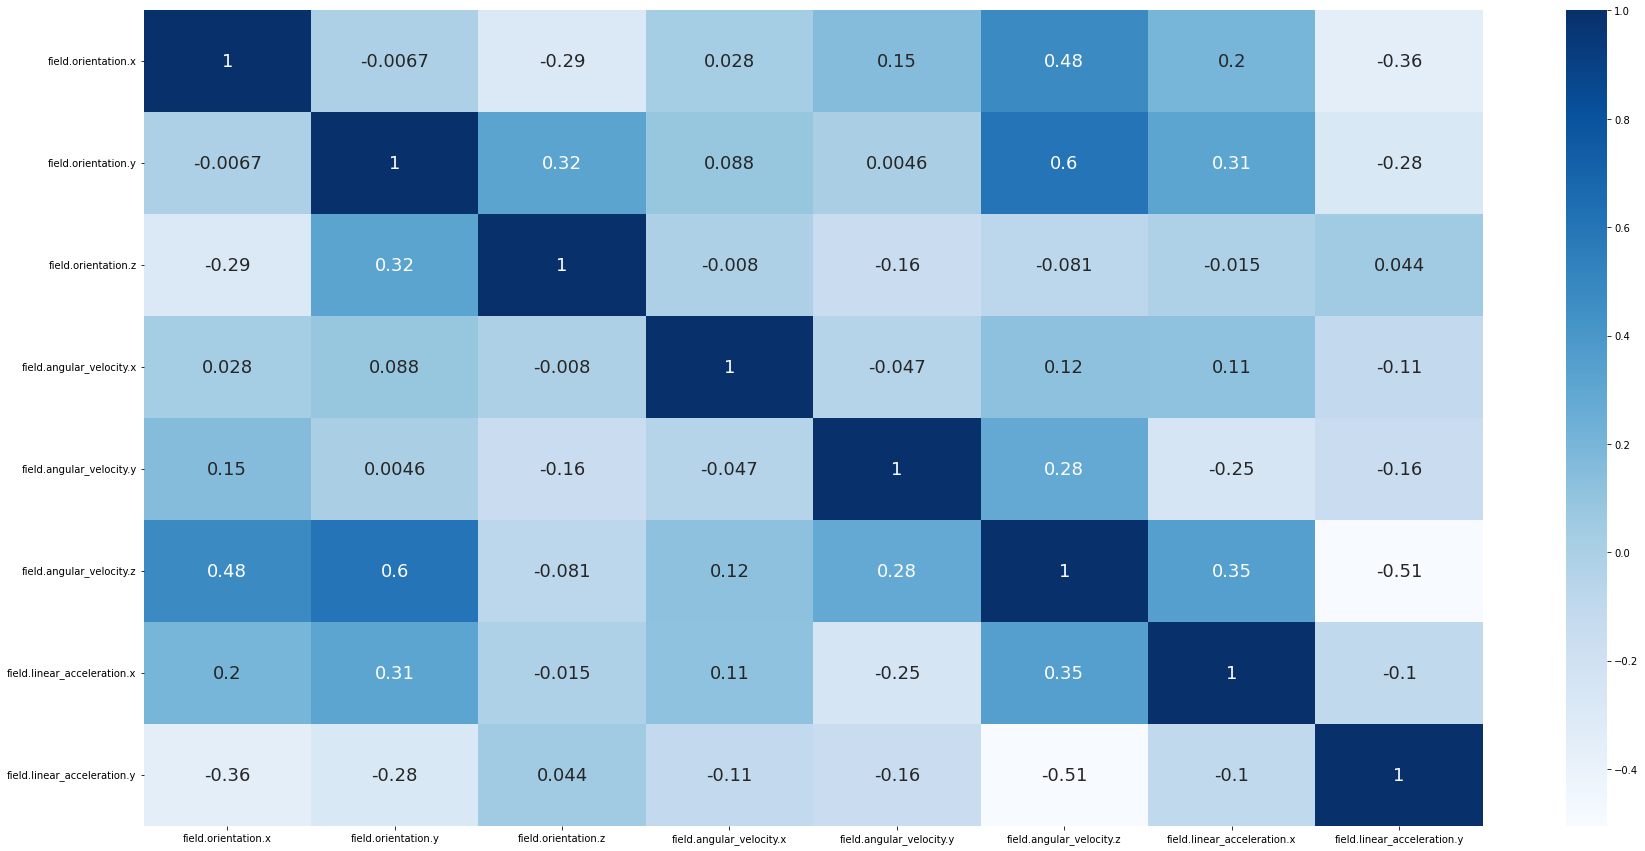

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(imu_data[imu_data.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [ ]:
imu_data

,field.orientation.x,field.orientation.y,field.orientation.z,field.orientation.w,field.angular_velocity.x,field.angular_velocity.y,field.angular_velocity.z,field.linear_acceleration.x,field.linear_acceleration.y,field.linear_acceleration.z
%time,,,,,,,,,,
2018-07-18 19:56:51.000,0.192816,0.035782,-0.058654,-0.978827,2.048229,-0.148680,0.189081,1.824037,-0.323619,14.817848
2018-07-18 19:56:51.050,0.192816,0.035782,-0.058654,-0.978827,2.048229,-0.148680,0.189081,1.824037,-0.323619,14.817848
2018-07-18 19:56:51.100,0.192816,0.035782,-0.058654,-0.978827,2.048229,-0.148680,0.189081,1.824037,-0.323619,14.817848
2018-07-18 19:56:51.150,0.192816,0.035782,-0.058654,-0.978827,2.048229,-0.148680,0.189081,1.824037,-0.323619,14.817848
2018-07-18 19:56:51.200,0.192816,0.035782,-0.058654,-0.978827,2.048229,-0.148680,0.189081,1.824037,-0.323619,14.817848
...,...,...,...,...,...,...,...,...,...,...
2018-07-18 19:59:02.950,-0.076616,-0.102990,-0.988213,-0.083416,0.036797,-0.132573,-0.143827,0.706079,0.362846,9.394771
2018-07-18 19:59:03.000,-0.076616,-0.102990,-0.988213,-0.083416,0.036797,-0.132573,-0.143827,0.706079,0.362846,9.394771
2018-07-18 19:59:03.050,-0.076616,-0.102990,-0.988213,-0.083416,0.036797,-0.132573,-0.143827,0.706079,0.362846,9.394771


## Plot time series

<ipython-input-10-c4dc29399469>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('/content/gdrive/MyDrive/processed/carbonZ_2018-07-18-16-37-39_1_no_failure/carbonZ_2018-07-18-16-37-39_1_no_failure-mavros-nav_info-velocity.csv',  error_bad_lines=False)


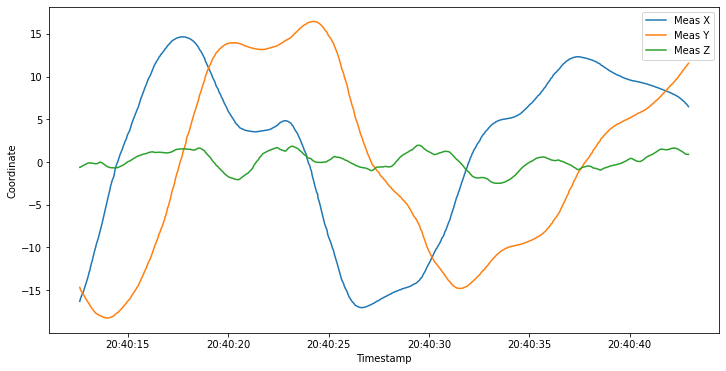

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# leggi i dati dal file e crea un DataFrame
df = pd.read_csv('/content/gdrive/MyDrive/processed/carbonZ_2018-07-18-16-37-39_1_no_failure/carbonZ_2018-07-18-16-37-39_1_no_failure-mavros-nav_info-velocity.csv',  error_bad_lines=False)

# converte il campo 'field.header.stamp' in un oggetto datetime
df['field.header.stamp'] = pd.to_datetime(df['field.header.stamp'], unit='ns')

# crea un nuovo DataFrame con le ultime tre colonne e la colonna 'field.header.stamp'
df_plot = df[['field.header.stamp', 'field.meas_x', 'field.meas_y', 'field.meas_z']]

# imposta la colonna 'field.header.stamp' come indice del DataFrame
df_plot = df_plot.set_index('field.header.stamp')

# crea il grafico
plt.figure(figsize=(12,6))
plt.plot(df_plot)
plt.xlabel('Timestamp')
plt.ylabel('Coordinate')
plt.legend(['Meas X', 'Meas Y', 'Meas Z'])
plt.show()


## Template creation

In [ ]:
metrics = ['mean', 'variance', 'mae', 'rmse', 'rms', 'kurtosis', 'skewness', 'impulse_factor', 'p25', 'p50', 'p75' ]

def create_stats(df):
  stats = pd.DataFrame()
  for column in df:
    if column == '%time':
       stats['%time'] = 'None'
    elif column == 'label':
      stats['label'] = 'None'
    else:
      for metric in metrics:
        name = column + '_' + metric
        stats[name] = 'None'
  return stats

In [ ]:
metrics = ['peak_frequency', 'peak_power', 'band_power', 'mean', 'p25', 'p50', 'p75']

def create_stats_fft(df):
  stats = pd.DataFrame()
  for column in df:
    if column == '%time':
       stats['%time'] = 'None'
    elif column == 'label':
      stats['label'] = 'None'
    else:
      for metric in metrics:
        name = column + '_' + metric
        stats[name] = 'None'
  return stats

## Feature frequencies


In [ ]:
import numpy as np

# Supponiamo che la tua trasformata di Fourier sia contenuta nella variabile "fft"
# Calcola la magnitudo della trasformata di Fourier
fft_mag = np.abs(fft)

# Trova l'indice del massimo valore di ampiezza nella trasformata di Fourier
max_idx = np.argmax(fft_mag)

# Trova la corrispondente frequenza della peak frequency
sampling_freq = 1000  # supponiamo che la frequenza di campionamento sia 1000 Hz
freqs = np.fft.fftfreq(len(fft_mag)) * sampling_freq
peak_freq = freqs[max_idx]


In [ ]:
# Supponiamo che la tua trasformata di Fourier sia contenuta nella variabile "fft"
# Calcola la magnitudo quadra della trasformata di Fourier
fft_mag_sq = np.square(np.abs(fft))

# Normalizza per la lunghezza dei dati e per la frequenza di campionamento
psd = fft_mag_sq / (len(data) * sampling_freq)


In [ ]:
# Supponiamo che la tua power spectral density sia contenuta nella variabile "psd"
# Definisci la banda di frequenza di interesse
freq_min = 8
freq_max = 12

# Trova gli indici corrispondenti alle frequenze minima e massima
freqs = np.fft.fftfreq(len(psd)) * sampling_freq
idx_min = np.argmax(freqs >= freq_min)
idx_max = np.argmax(freqs >= freq_max)

# Calcola l'integrale della power spectral density nella banda di frequenza di interesse
band_power = np.trapz(psd[idx_min:idx_max], freqs[idx_min:idx_max])


In [ ]:


# splitting data into training and test set for independent attributes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test =train_test_split(columns50.drop('label',axis=1), columns50['label'], test_size=.3,
                                                   random_state=22)
X_train.shape,X_test.shape
#developing a model
clf_pruned = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=10, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)
#visualizing the tree
import io
from io import StringIO
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz
xvar = columns50.drop('label', axis=1)
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1','2', '3','4', '5', '6', '7', '8'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## Merge tables

In [ ]:

# Definisci la directory dei file CSV
directory = '/content/gdrive/MyDrive/ManutenzionePreventiva/failures/no_failure'

# Lista di tutti i file nella directory
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# Leggi ogni file CSV e uniscilo al dataframe
df = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(directory, file)
    temp_df = pd.read_csv(file_path)
    df = pd.concat([df, temp_df])

df = df.dropna()
df.set_index('%time', inplace=True)
df['label'] = df['field.data'].astype(int)
df = df.drop(columns=['field.data'])


Si salva ognuno dei dataframe creati in un file csv. Ogni file csv conterrà i dati di un unico guasto. 

In [ ]:
df.to_csv('/content/gdrive/MyDrive/ManutenzionePreventiva/failures/no_failure.csv', index_label = '%time') 